In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import svm
import numpy as np
import os
import json
import joblib
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import create_directory

# Load feature vector

In [2]:
train_feature_path = os.path.join(create_directory.marvel_dir, "feature/Train")
test_feature_path = os.path.join(create_directory.marvel_dir, "feature/Test")

# HOG + Openface
train_hog_openface_feature_path = os.path.join(train_feature_path, "hog_openface")
test_hog_openface_feature_path = os.path.join(test_feature_path, "hog_openface")
# MTCNN + Facenet
train_mtcnn_facenet_feature_path = os.path.join(train_feature_path, "mtcnn_facenet")
test_mtcnn_facenet_feature_path = os.path.join(test_feature_path, "mtcnn_facenet")

In [3]:
def get_feature(feature_path, feature_extraction_type):
    list_feature = []
    list_label = []
    if feature_extraction_type=="openface":
        size = 128
    elif feature_extraction_type=="facenet":
        size = 512
    for i in os.listdir(feature_path):
        if i==".DS_Store":
            continue
        for j in os.listdir(os.path.join(feature_path, i)):
            if j==".DS_Store":
                continue
            list_label.append(i)
            feature=np.load(os.path.join(os.path.join(feature_path, i), j))
            list_feature.append(feature.reshape(size).tolist())
    return list_label, list_feature

In [4]:
# HOG-Openface (ho)
list_train_ho_label, list_train_ho_feature = get_feature(train_hog_openface_feature_path, feature_extraction_type="openface")
list_test_ho_label, list_test_ho_feature = get_feature(test_hog_openface_feature_path, feature_extraction_type="openface")
# MTCNN-Facenet (mf)
list_train_mf_label, list_train_mf_feature = get_feature(train_mtcnn_facenet_feature_path, feature_extraction_type="facenet")
list_test_mf_label, list_test_mf_feature = get_feature(test_mtcnn_facenet_feature_path, feature_extraction_type="facenet")

# Prepare for training

In [5]:
# Face label to index
label2idx = {'Chris Evans':0, 'Chris Hemsworth':1, 'Mark Ruffalo':2, 'Robert Downey Jr':3, 
             'Scarlett Johansson':4, 'Tom Holland':5, 'Unknown':6}
list_train_ho_idx = []
list_train_mf_idx = []
list_test_ho_idx = []
list_test_mf_idx = []
for i in list_train_ho_label:
    list_train_ho_idx.append(label2idx[i])
for i in list_train_mf_label:
    list_train_mf_idx.append(label2idx[i])
for i in list_test_ho_label:
    list_test_ho_idx.append(label2idx[i])
for i in list_test_mf_label:
    list_test_mf_idx.append(label2idx[i])
with open(os.path.join(create_directory.recognition_model_dir, "label2idx.json"), "w") as outfile:
    json.dump(label2idx, outfile)

In [6]:
svm_model_hog_openface_path = os.path.join(create_directory.recognition_model_dir, "hog_openface_svm_model.sav")
svm_model_mtcnn_facenet_path = os.path.join(create_directory.recognition_model_dir, "mtcnn_facenet_svm_model.sav")
knn_model_hog_openface_path = os.path.join(create_directory.recognition_model_dir, "hog_openface_knn_model.sav")
knn_model_mtcnn_facenet_path = os.path.join(create_directory.recognition_model_dir, "mtcnn_facenet_knn_model.sav")

In [7]:
# HOG-Openface
ho_x_train = list_train_ho_feature
ho_x_test = list_test_ho_feature
ho_y_train = list_train_ho_idx
ho_y_test = list_test_ho_idx
# MTCNN-Facenet
mf_x_train = list_train_mf_feature
mf_x_test = list_test_mf_feature
mf_y_train = list_train_mf_idx
mf_y_test = list_test_mf_idx

# Face recognition

In [8]:
def train_model(x_train, x_test, y_train, y_test, data_size, model_type, save, model_path):
    if data_size == "small":
        # Nếu dữ liệu nhỏ, ta chia dữ liệu train ra, nếu dữ liệu lớn, ta không làm gì
        x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.33,
                                                    random_state=4, stratify=y_train)
    print("Fitting the classifier to the training set")
    if model_type == 'svm':
        # Training SVM model
        param_grid = {
                'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
                }
        clf = GridSearchCV(svm.SVC(kernel='rbf', class_weight='balanced'), param_grid)
    elif model_type == 'knn':
        # Training KNN model
        param_grid = {
                'n_neighbors': [3, 5, 7]
                }
        clf = GridSearchCV(KNeighborsClassifier(weights='distance'), param_grid)
    clf = clf.fit(x_train, y_train)
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)
    if save == 1:
        joblib.dump(clf, model_path)
    print(model_type + " accuracy: ")
    y_pred = clf.predict(x_test)
    print(accuracy_score(y_test, y_pred))
    return y_test, y_pred

In [9]:
# Plot confusion matrix
idx2label = {y: x for x, y in label2idx.items()}
def plot_confusion_matrix(array):
    df_cm = pd.DataFrame(array, index = [idx2label[i] for i in range(7)], 
                        columns = [idx2label[i] for i in range(7)])
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.show()

## SVM

### HOG + Openface 

#### Large Dataset

In [10]:
y_test, y_pred = train_model(ho_x_train, ho_x_test, ho_y_train, ho_y_test, "large", "svm", 0, svm_model_hog_openface_path)

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=10000.0, class_weight='balanced', gamma=0.0001)
svm accuracy: 
0.8791773778920309


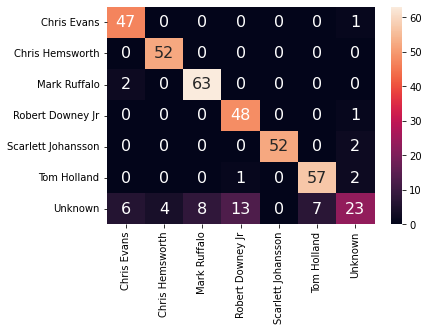

In [11]:
array = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(array)

#### Small Dataset

In [12]:
y_test, y_pred = train_model(ho_x_train, ho_x_test, ho_y_train, ho_y_test, "small", "svm", 1, svm_model_hog_openface_path)

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.001)
svm accuracy: 
0.8969555035128806


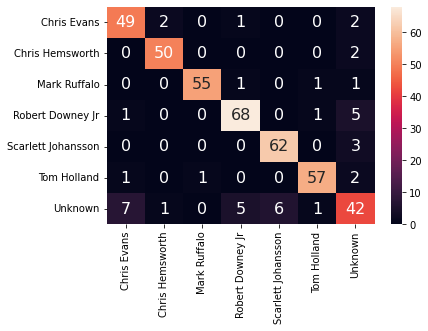

In [13]:
array = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(array)

### MTCNN + Facenet 

#### Large Dataset

In [14]:
y_test, y_pred = train_model(mf_x_train, mf_x_test, mf_y_train, mf_y_test, "large", "svm", 0, svm_model_mtcnn_facenet_path)

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.0005)
svm accuracy: 
0.9817708333333334


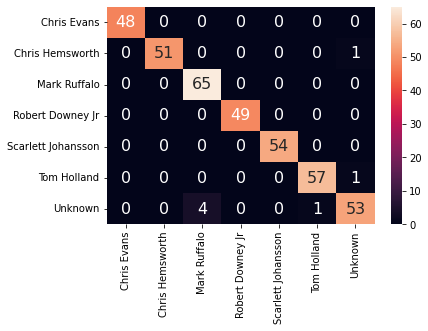

In [15]:
array = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(array)

#### Small Dataset

In [16]:
y_test, y_pred = train_model(mf_x_train, mf_x_test, mf_y_train, mf_y_test, "small", "svm", 1, svm_model_mtcnn_facenet_path)

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.0001)
svm accuracy: 
0.9902439024390244


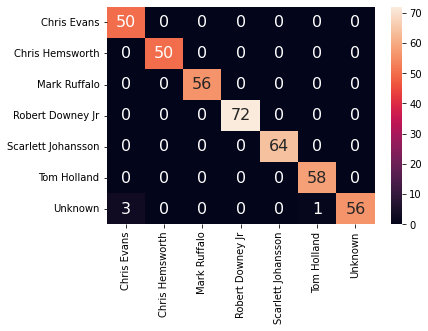

In [17]:
array = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(array)

## KNN

### HOG + Openface 

#### Large Dataset

In [18]:
y_test, y_pred = train_model(ho_x_train, ho_x_test, ho_y_train, ho_y_test, "large", "knn", 0, svm_model_hog_openface_path)

Fitting the classifier to the training set
Best estimator found by grid search:
KNeighborsClassifier(n_neighbors=3, weights='distance')
knn accuracy: 
0.8688946015424165


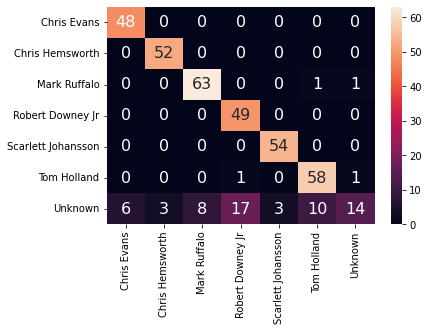

In [19]:
array = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(array)

#### Small Dataset

In [20]:
y_test, y_pred = train_model(ho_x_train, ho_x_test, ho_y_train, ho_y_test, "small", "knn", 1, svm_model_hog_openface_path)

Fitting the classifier to the training set
Best estimator found by grid search:
KNeighborsClassifier(weights='distance')
knn accuracy: 
0.8805620608899297


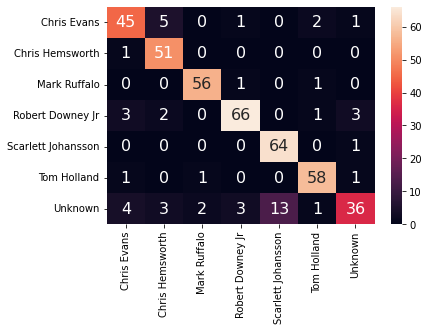

In [21]:
array = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(array)

### MTCNN + Facenet

#### Large Dataset

In [22]:
y_test, y_pred = train_model(mf_x_train, mf_x_test, mf_y_train, mf_y_test, "large", "knn", 0, svm_model_mtcnn_facenet_path)

Fitting the classifier to the training set
Best estimator found by grid search:
KNeighborsClassifier(n_neighbors=3, weights='distance')
knn accuracy: 
0.90625


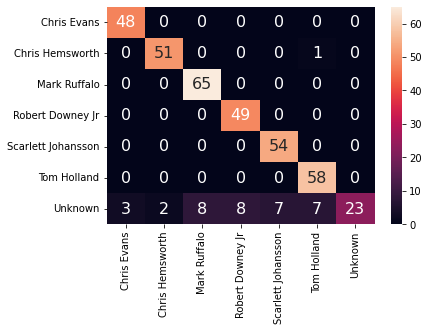

In [23]:
array = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(array)

#### Small Dataset

In [24]:
y_test, y_pred = train_model(mf_x_train, mf_x_test, mf_y_train, mf_y_test, "small", "knn", 1, svm_model_mtcnn_facenet_path)

Fitting the classifier to the training set
Best estimator found by grid search:
KNeighborsClassifier(n_neighbors=3, weights='distance')
knn accuracy: 
0.9853658536585366


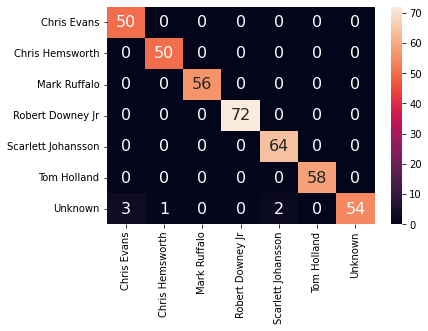

In [25]:
array = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(array)